# Decision Analysis and Policy Evaluation

Up to this point, the analysis has focused on validating the predictive models from a statistical and behavioral perspective — including discrimination, calibration, interpretability, stability over time, and segment-level error analysis. Having established that the models behave in a consistent and sensible way, the purpose of this notebook is to shift the focus from model quality to decision impact. In other words, we now explore how model scores translate into concrete credit decisions and what trade-offs emerge when those scores are used to define approval policies.

This notebook will explore how approval rates, risk concentration, and loss proxies shift as we adjust score cut-offs, helping us understand how the portfolio’s composition changes when criteria are tightened or relaxed. Rather than making claims about absolute profitability or optimal decisions, the focus is on comparing how risk levels and volume distribution vary across score ranges and how different models behave when applied to the same approval context.

In [1]:
import sys

sys.path.append("..")

import pandas as pd
from functions import performance_report, default_report

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
TARGET = "default_binary"
XGB_SCORE_COLUMN = "xgb_pred_calibrated"
LR_SCORE_COLUMN = "lr_pred_calibrated"

data = pd.read_parquet("../data/scored_calibrated_data.parquet")

train_data = data[data["dataset"] == "train"].copy()
validation_data = data[data["dataset"] == "validation"].copy()

# Understanding Current Policy

To begin, we’ll examine the dataset to interpret the decision policy currently implemented by the company. Applicant risk segmentation is based on the `loan_grade` and `loan_subgrade` features. By analyzing these groups, we can observe patterns in average loan amounts, interest rates, and the share of approved applicants across different risk bands.

For example, a much smaller population in the riskiest subgrades might point to stricter approval rules for high-risk applicants, even if these individuals are offered higher interest rates. On the other hand, seeing higher volumes or relatively favorable rates in certain subgrades could signal a targeted risk appetite or strategic business positioning. This analysis enables us to infer the logic of approval strategies, risk-based pricing patterns, and business rules that define the current lending approach. It also highlights whether the acceptance policy is applied consistently or if there is special caution in specific segments. Building on these insights, we can later link observed patterns to model-predicted scores and simulate the impact of changing approval policy.

In [3]:
with pd.option_context("display.max_columns", None):
    summary = validation_data.groupby("loan_grade")[
        ["default_binary", "loan_amount_funded", "interest_rate"]
    ].mean()
    summary["count"] = validation_data.groupby("loan_grade").size()
    summary["default_binary"] = summary["default_binary"].map(lambda x: f"{x:.1%}")
    summary["interest_rate"] = summary["interest_rate"].map(lambda x: f"{x:.1%}")
    summary["loan_amount_funded"] = summary["loan_amount_funded"].map(lambda x: f"${x:,.0f}")

    display(summary.T)

    summary = validation_data.groupby("loan_subgrade")[
        ["default_binary", "loan_amount_funded", "interest_rate"]
    ].mean()
    summary["count"] = validation_data.groupby("loan_subgrade").size()
    summary["default_binary"] = summary["default_binary"].map(lambda x: f"{x:.1%}")
    summary["interest_rate"] = summary["interest_rate"].map(lambda x: f"{x:.1%}")
    summary["loan_amount_funded"] = summary["loan_amount_funded"].map(lambda x: f"${x:,.0f}")

    display(summary.T)

loan_grade,A,B,C,D,E,F,G
default_binary,4.6%,11.0%,18.5%,24.7%,29.0%,36.0%,38.6%
loan_amount_funded,"$13,918","$12,068","$12,370","$14,311","$13,173","$13,256","$17,279"
interest_rate,6.9%,10.5%,14.0%,18.2%,24.1%,29.4%,30.9%
count,10033,17051,13566,5328,1581,286,57


loan_subgrade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
default_binary,2.6%,4.2%,5.1%,5.2%,6.6%,8.6%,9.1%,11.2%,11.8%,13.6%,16.7%,17.8%,18.6%,20.1%,20.7%,23.5%,23.6%,24.6%,28.3%,41.0%,27.7%,29.1%,27.1%,30.0%,36.1%,33.3%,36.8%,30.8%,48.5%,41.4%,20.0%,33.3%,33.3%,100.0%,64.3%
loan_amount_funded,"$13,743","$13,822","$14,429","$14,743","$13,130","$12,479","$12,222","$11,814","$11,788","$11,955","$11,967","$11,754","$11,753","$13,474","$13,217","$14,016","$14,532","$14,793","$13,883","$13,864","$13,652","$13,085","$13,425","$11,474","$13,565","$12,342","$12,071","$12,442","$16,655","$16,667","$21,176","$12,556","$14,772","$19,450","$17,059"
interest_rate,5.3%,7.0%,7.2%,7.5%,8.0%,8.2%,10.5%,11.4%,11.4%,11.5%,12.7%,13.5%,14.0%,15.0%,16.0%,17.0%,18.0%,19.0%,20.0%,21.5%,22.7%,24.0%,24.7%,25.5%,26.2%,28.7%,29.5%,30.0%,30.5%,30.7%,30.8%,30.8%,30.9%,30.9%,31.0%
count,2727,1719,1625,1820,2142,4043,2631,2705,3096,4576,3828,2764,2272,2606,2096,1718,1570,1135,844,61,537,402,291,207,144,147,38,39,33,29,20,12,9,2,14


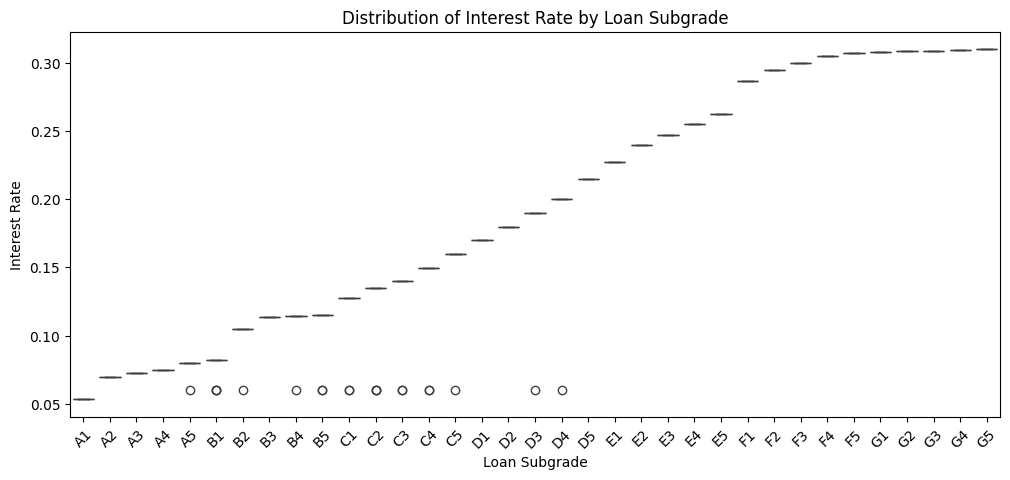

In [4]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=validation_data.sort_values("loan_subgrade"),
    x="loan_subgrade",
    y="interest_rate",
    order=sorted(validation_data["loan_subgrade"].unique()),
)
plt.title("Distribution of Interest Rate by Loan Subgrade")
plt.xlabel("Loan Subgrade")
plt.ylabel("Interest Rate")
plt.xticks(rotation=45)
plt.show()

The grade and subgrade breakdown reveals a very clear and economically intuitive pattern. As we move from safer to riskier bands, default rates increase monotonically, and this increase is closely matched by a stepwise rise in the interest rates charged. This strongly suggests that the company is operating under a risk-based pricing framework, where higher expected risk is explicitly compensated through higher rates rather than being addressed solely via rejection. In other words, acceptance and pricing appear to be jointly optimized, not treated as independent decisions. Also, there does not appear to be a consistent shift in the approved loan amount across risk bands, as funded loan amounts remain fairly stable in the 13–14k range for all grades. This indicates that lending limits are not being systematically adjusted alongside risk or pricing.

At the same time, volume distribution across grades provides important additional context. While interest rates continue to increase in the riskiest grades and subgrades, the number of approved loans drops sharply in these regions. This indicates that pricing alone is not the only control mechanism: there is also a clear approval filter that limits exposure to the highest-risk applicants. The very small counts observed in the worst subgrades (particularly in F and G) suggest that these segments may be deliberately kept thin, either due to internal risk limits, regulatory considerations, or to maintain optionality for future policy adjustments without materially impacting portfolio performance.

# Impact of Existing Credit Policy

At this point, it is important to recognize that the observed outcomes in this dataset are the result of an existing credit policy, not of a random sampling of applicants. The grade and subgrade distributions, combined with sharply decreasing volumes in the riskiest bands and increasing interest rates, strongly suggest that the data reflects a policy-conditioned population: applicants are first filtered by approval rules and then priced according to risk.

Because of this, directly comparing a new model’s score to observed defaults would be misleading. The realized default rates already embed at least two structural biases:
1. Approval bias: the riskiest applicants are partially or fully filtered out, especially in the worst subgrades.
2. Risk-based pricing effects: higher-risk borrowers face higher interest rates, which can itself influence repayment behavior and observed default rates.

To address this, the first step is to reconstruct a proxy for the current decision score implied by the existing policy. We do this by mapping each loan subgrade to its empirical default rate and treating this mapping as a baseline risk score. This allows us to translate the company’s categorical grading system into a continuous probability-like measure that reflects how risk is currently segmented and accepted in practice.

This reconstructed score does not represent an unbiased estimate of true applicant risk. Instead, it serves as a policy-consistent benchmark: a way to compare alternative models under the same approval and selection constraints. Only after anchoring the analysis to this baseline can we fairly evaluate lift, cumulative defaults, and portfolio composition changes when replacing or augmenting the current policy with a new model.

In the next steps, we will therefore:
- compare model scores against this policy-implied baseline rather than raw outcomes,
- analyze lift, cumulative default, and risk concentration under matched approval rates,
- and explicitly assess where differences come from improved ranking versus policy-induced bias.

This framing allows us to evaluate incremental model value while respecting the structural constraints imposed by the existing credit policy. 

In [5]:
subgrade_default_map = train_data.groupby("loan_subgrade")[TARGET].mean().to_dict()
validation_data["current_score"] = validation_data["loan_subgrade"].map(subgrade_default_map)

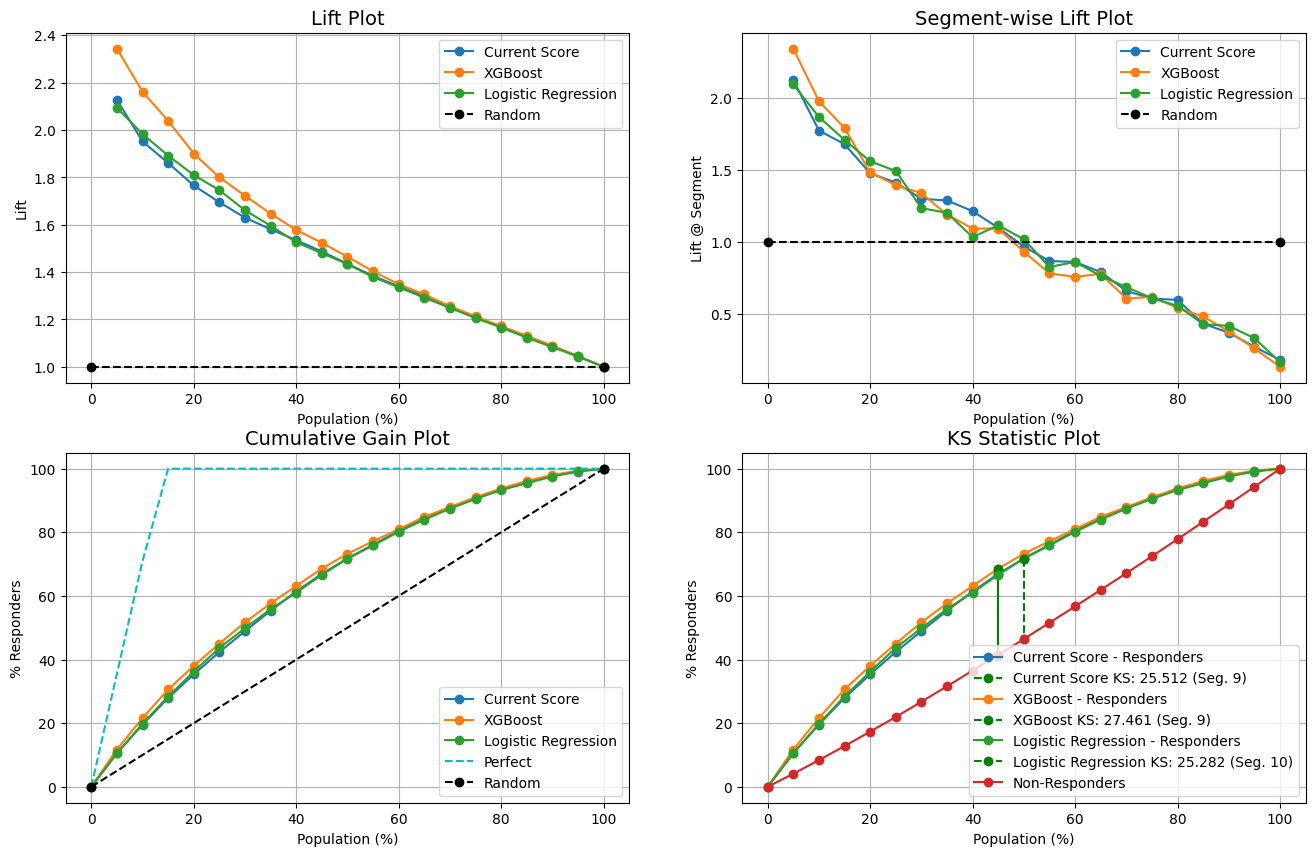

In [6]:
models = {
    "Current Score": validation_data["current_score"],
    "XGBoost": validation_data[XGB_SCORE_COLUMN],
    "Logistic Regression": validation_data[LR_SCORE_COLUMN],
}

st = performance_report(validation_data[TARGET], models, labels=False, n_segments=20)

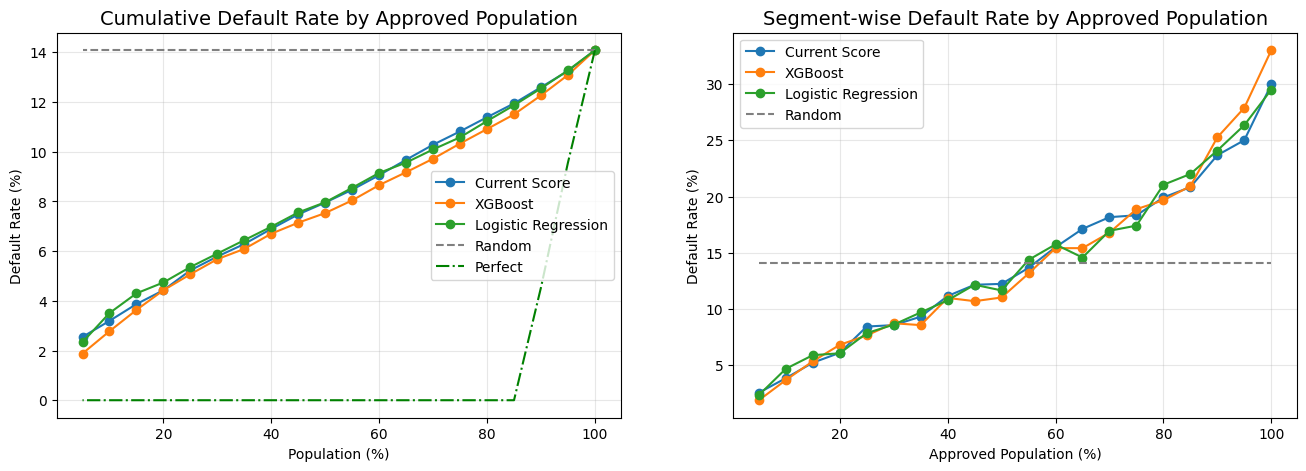

In [7]:
st = default_report(validation_data[TARGET], models, labels=False, n_segments=20)

Looking at the lift, cumulative gains, KS, and cumulative default curves, the first conclusion is that all three scores — the inferred current policy score, logistic regression, and XGBoost — produce broadly similar ordering of risk within the approved population. XGBoost consistently delivers the strongest lift in the top segments and the highest KS statistic, followed closely by logistic regression, with the current policy score trailing slightly behind. This indicates that the alternative models are extracting additional discriminatory power from the same applicant information, even when evaluated on data that has already been shaped by an existing approval and pricing policy. Importantly, the separation gains are most visible in the early population percentiles, which is precisely where a credit granting model delivers the most business value.

At the same time, these results must be interpreted with caution. The evaluation sample is not policy-neutral: observed outcomes reflect a portfolio that has already been filtered by Lending Club’s approval rules and risk-based pricing strategy. High-risk applicants are underrepresented, and interest rates are explicitly correlated with subgrade, which in turn is correlated with default outcomes. As a result, the inferred "current score" and the newly trained models are not being compared on a fully counterfactual population. What these plots primarily tell us is that, conditional on the approved population, the new models provide a more efficient ranking of relative risk. A fairer comparison would require either restricting evaluation to regions of strong overlap between policies, applying rejection inference techniques, or framing the analysis as a policy simulation exercise (e.g., fixing approval volume or target default rate and comparing implied portfolios). This framing clarifies that the observed gains are incremental improvements within an existing policy regime, rather than a direct statement about absolute performance in a fully unconstrained decision setting.

# Dealing with Biases

## What the dataset does not contain
There are two critical elements that the dataset does not provide. First, we don't know if there is randomization in approval or pricing (probably not): interest rates are almost entirely determined by loan subgrade, which in turn is generated by the production scoring system. Second, there is no meaningful variation of pricing within subgrade. Because pricing directly affects borrower behavior and default outcomes, this endogeneity prevents a clean interpretation of observed risk improvements as direct monetary gains. In other words, while we can observe differences in risk ordering, we cannot directly translate these differences into expected profit or loss reductions without making additional assumptions. Any statement such as "a lift improvement of X implies a monetary gain of Y" would be unjustified with the available data.

## What would be required for a causal evaluation
In an ideal setting, this limitation would be addressed through randomized or exploratory data. The most straightforward solution would be randomized pricing experiments (or shadow pricing), where applicants with similar risk profiles are offered different interest rates, allowing direct estimation of price elasticity and its impact on default. Even limited randomization — for example, small pricing perturbations within subgrades or randomized pricing for marginal segments — would make it possible to disentangle latent risk from pricing effects and evaluate new models more causally. While full randomization in the highest-risk bands may be prohibitively expensive, partial experimentation in selected bands would already provide substantial value.

## A pragmatic path forward with assumption-driven adjustments
Given that such data is not available here, the most defensible path forward is to proceed with an explicitly assumption-driven adjustment, rather than treating observed defaults as immutable truths. One pragmatic approach is to assume a reasonable elasticity of default with respect to pricing, calibrated from external evidence or conservative internal benchmarks. Under this framework, when a new model reorders applicants across subgrades, individual risk estimates can be adjusted to reflect the expected default behavior under the pricing associated with the new subgrade, rather than the historical one. For example, if an applicant historically priced as E2 would be reclassified to B3 by a challenger model, their expected default rate should be adjusted toward the typical default level observed under B3 pricing. While this does not eliminate bias, it directly addresses the dominant pricing channel and yields a comparison that is substantially more coherent than using raw observed outcomes.

## Remaining bias: approval filters and swap symmetry
After applying such pricing-adjusted risk estimates, the remaining bias primarily relates to approval filters. Without randomized approvals, this cannot be fully resolved. A reasonable and commonly used assumption in this setting is swap symmetry: the marginal applicants swapped into approval by the new model are assumed to be statistically similar (in aggregate risk) to those swapped out by the old policy. This assumption is most defensible when gains are concentrated in middle to lower risk bands — as observed in the earlier analyses — rather than at the extreme tails. Under this assumption, portfolio-level comparisons become interpretable as incremental improvements around the existing policy frontier, rather than as wholesale regime changes.

## Pricing adjustment as an explicit modeling assumption

Here we do not attempt to recover fully causal counterfactual outcomes. Instead, we make pricing effects explicit by modeling only the mechanical affordability channel. This choice is deliberate. Given that interest rates are almost entirely determined by subgrade, any re-ranking of applicants across subgrades necessarily implies a change in pricing. Ignoring this channel would implicitly assume that default risk is invariant to payment burden, which is economically indefensible.

Because we lack fully randomized pricing data, we must take an explicitly assumption-driven approach: we posit how risk responds to pricing changes, allowing us to proceed transparently and consistently with our analysis. Specifically, we define an adjusted score as follows:

$$\text{score}_{\text{adjusted}}
=
f\big(
\text{score}_{\text{model}},
 g_{\text{old}},
 g_{\text{new}}
\big)$$

where the adjustment operates exclusively through the implied change in payment burden associated with the subgrade transition.

## Step A — Mapping subgrades to payment burden

For each loan subgrade ( $g$ ), we estimate a representative interest rate ( $r_g$ ), for example the median observed `interest_rate` within that subgrade. Loan maturity ( $T$ ) is taken from the observed `loan_term_months` (36 here) and can be handled at the individual-loan level.

Given loan amount ( $L$ ), the monthly payment of a fully amortizing loan is approximated by:

$$
\text{PMT}(r, T, L)
= 
L \cdot
\frac{i(1+i)^T}{(1+i)^T - 1},
\qquad
i = \frac{r}{12}$$

When an applicant is reassigned from an original subgrade ( $g_{\text{old}}$ ) to a new subgrade ( $g_{\text{new}}$ ), we quantify the pricing shock as the relative change in monthly payment:

$$
\Delta \log \text{PMT}
=
\log\left(
\frac{\text{PMT}(r_{g_{\text{new}}}, T, L)}
{\text{PMT}(r_{g_{\text{old}}}, T, L)}
\right)
$$

This quantity is positive when the new pricing implies higher payments and negative when pricing becomes more favorable. By working in relative (log) terms, the adjustment is naturally scale-free and comparable across loan sizes and maturities.

## Step B — Adjusting default risk via payment elasticity

Default risk is adjusted in log-odds space, using an explicit elasticity that links proportional changes in payment burden to proportional changes in default odds:

$$
\text{logit}\left(PD_{\text{adjusted}}\right)
=
\text{logit}\left(PD_{\text{model}}\right)
+
\beta_{\text{pmt}} \cdot \Delta \log \text{PMT}
$$

Where:

* $PD_{\text{model}}$ is the raw predicted default probability from the challenger model,
* $\beta_{\text{pmt}}$ is the elasticity of default odds with respect to payment burden.

This formulation is intentionally simple, monotonic, and transparent. It preserves the relative ordering produced by the model while shifting risk levels in a way that is economically interpretable and suitable for governance review.

## Choice of elasticity $\beta_{\text{pmt}}$

Because the dataset contains no pricing randomization, $\beta_{\text{pmt}}$ cannot be estimated internally and must be treated as an explicit modeling assumption.

Empirical evidence from the consumer credit literature — including studies of interest-rate resets, refinancing shocks, and payment relief programs — consistently shows that, in the US, higher required payments increase delinquency and default, even holding borrower characteristics constant. Translating these findings into a parsimonious log-odds framework suggests a conservative and defensible range:


$$\beta_{\text{pmt}} \in [1.0,2.0]$$


Interpretation: a 10% increase in monthly payment implies an increase in default odds of approximately 10%–22%, since


$$\exp\left(\beta_{\text{pmt}} \cdot \log(1.1)\right)$$


falls within this interval for $\beta_{\text{pmt}} \in [1,2]$. This magnitude is economically plausible for unsecured personal loans and directly tied to the affordability channel, rather than behavioral or selection effects.

In [8]:
import numpy as np

BETA_PMT_LIST = [1.0, 2.0]
EPS = 1e-12


def logit(p):
    p = np.clip(p, EPS, 1 - EPS)
    return np.log(p / (1 - p))


def sigmoid(z):
    return 1 / (1 + np.exp(-z))

The first step is to create the new subgrade columns; from now on, we will focus only on the XGB model. We will use the same proportions as before, without any changes, as mentioned earlier.

In [9]:
subgrade_counts = train_data["loan_subgrade"].value_counts().sort_index()
subgrade_cumsum = [0] + subgrade_counts.values.cumsum().tolist()

pd_sorted_by_score = train_data.sort_values(by="xgb_pred_calibrated").reset_index(drop=True)
group_indices = np.repeat(np.arange(len(subgrade_cumsum) - 1), np.diff(subgrade_cumsum))

min_pd_per_group = pd_sorted_by_score["xgb_pred_calibrated"].groupby(group_indices).min().values
max_pd_per_group = pd_sorted_by_score["xgb_pred_calibrated"].groupby(group_indices).max().values
subgrade_pd_min_max = np.stack([min_pd_per_group, max_pd_per_group], axis=1)

subgrades_lc = [
    "A1",
    "A2",
    "A3",
    "A4",
    "A5",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "C1",
    "C2",
    "C3",
    "C4",
    "C5",
    "D1",
    "D2",
    "D3",
    "D4",
    "D5",
    "E1",
    "E2",
    "E3",
    "E4",
    "E5",
    "F1",
    "F2",
    "F3",
    "F4",
    "F5",
    "G1",
    "G2",
    "G3",
    "G4",
    "G5",
]

n_subgrades = len(subgrades_lc)
quantile_edges = np.linspace(0, 1, n_subgrades + 1)
train_pd_values = train_data["xgb_pred_calibrated"].values.copy()
subgrade_quantile_thresholds = np.quantile(train_pd_values, quantile_edges)


def scores_to_subgrade_labels(pd_scores):
    idx = np.searchsorted(subgrade_quantile_thresholds, pd_scores, side="right") - 1
    idx = np.clip(idx, 0, n_subgrades - 1)
    return np.array(subgrades_lc)[idx]


for df in (train_data, validation_data):
    df["loan_subgrade_xgb"] = scores_to_subgrade_labels(df["xgb_pred_calibrated"].values)

In [10]:
# 1) Map subgrade -> representative rate r_g (median in train)
subgrade_rate_map = train_data.groupby("loan_subgrade")["interest_rate"].median()

for df in (train_data, validation_data):
    df["r_old"] = df["loan_subgrade"].map(subgrade_rate_map)
    df["r_new"] = df["loan_subgrade_xgb"].map(subgrade_rate_map)

for df in (train_data, validation_data):
    df["r_new"] = df["r_new"].fillna(df["r_old"])

validation_data[["interest_rate", "r_old", "r_new"]].head()

,interest_rate,r_old,r_new
942105,0.0749,0.0749,0.1049
942106,0.1144,0.1099,0.0749
942107,0.0699,0.0649,0.1274
942108,0.1139,0.1049,0.0649
942109,0.0699,0.0649,0.0532


In [11]:
# 2) Compute payment burden shock: Δ log PMT
# PMT(L, r, T) = L * i * (1+i)^T / ((1+i)^T - 1),  i = r/12
def pmt(amount, rate_annual, term_months):
    i = rate_annual / 12.0
    T = term_months.astype(float)

    # Handle zero/near-zero rates safely
    # If i ~ 0, PMT ~ L/T
    near_zero = np.isclose(i, 0.0)
    out = np.empty_like(amount, dtype=float)

    # Standard amortization
    i_nz = np.where(near_zero, 1e-9, i)
    pow_ = np.power(1.0 + i_nz, T)
    out_std = amount * (i_nz * pow_) / (pow_ - 1.0)

    # Zero-rate approximation
    out_zero = amount / np.clip(T, 1.0, None)

    out = np.where(near_zero, out_zero, out_std)
    return out


for df in (train_data, validation_data):
    L = df["loan_amount_funded"].astype(float).to_numpy()
    T = df["loan_term_months"].astype(float).to_numpy()

    pmt_old = pmt(L, df["r_old"].astype(float).to_numpy(), T)
    pmt_new = pmt(L, df["r_new"].astype(float).to_numpy(), T)

    # Δ log PMT > 0 means higher payment burden under new subgrade pricing
    df["pmt_old"] = pmt_old
    df["pmt_new"] = pmt_new
    df["pmt_ratio"] = pmt_new / pmt_old
    df["delta_log_pmt"] = np.log(np.clip(pmt_new, EPS, None) / np.clip(pmt_old, EPS, None))

validation_data[
    ["interest_rate", "r_old", "r_new", "pmt_old", "pmt_new", "pmt_ratio", "delta_log_pmt"]
].head()

,interest_rate,r_old,r_new,pmt_old,pmt_new,pmt_ratio,delta_log_pmt
942105,0.0749,0.0749,0.1049,311.016257,324.977284,1.044888,0.043910
942106,0.1144,0.1099,0.0749,425.541762,404.321134,0.950133,-0.051154
942107,0.0699,0.0649,0.1274,92.699466,101.545790,1.095430,0.091147
942108,0.1139,0.1049,0.0649,292.479556,275.800063,0.942972,-0.058719
942109,0.0699,0.0649,0.0532,367.733418,361.377375,0.982716,-0.017435


Since the index is in logarithmic scale, Δ log PMT approximately represents the percentage change in the installment value. For example, a Δ log PMT of 0.043 corresponds to about a 4.3% increase in payment.

In [12]:
# 3) Adjust PD in log-odds space
# logit(PD_adj) = logit(PD_model) + beta_pmt * Δ log PMT
beta = 1.5
for df in (train_data, validation_data):
    base_pd = df["xgb_pred_calibrated"].astype(float).to_numpy()
    z = logit(base_pd) + beta * df["delta_log_pmt"].astype(float).to_numpy()
    df["xgb_score_adjusted"] = sigmoid(z)

validation_data[["r_old", "r_new", "xgb_pred_calibrated", "xgb_score_adjusted"]].head()

,r_old,r_new,xgb_pred_calibrated,xgb_score_adjusted
942105,0.0749,0.1049,0.067742,0.072022
942106,0.1099,0.0749,0.044636,0.041476
942107,0.0649,0.1274,0.094412,0.106768
942108,0.1049,0.0649,0.024311,0.022307
942109,0.0649,0.0532,0.023703,0.023105


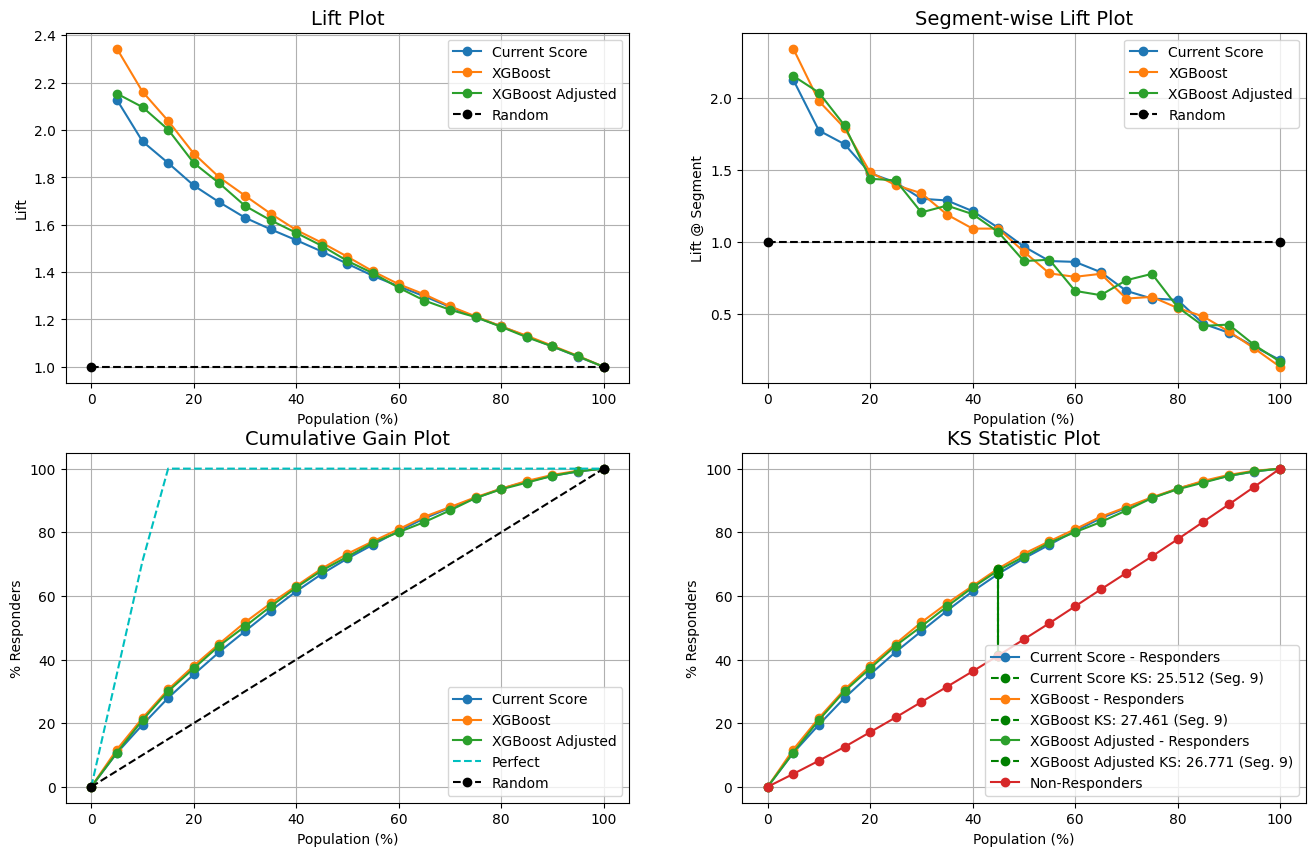

In [13]:
models = {
    "Current Score": validation_data["current_score"],
    "XGBoost": validation_data[XGB_SCORE_COLUMN],
    "XGBoost Adjusted": validation_data["xgb_score_adjusted"],
}

st = performance_report(validation_data[TARGET], models, labels=False, n_segments=20)

An important structural characteristic of this dataset is its long maturation window: loans take up to 36 months to fully resolve, and all observed default outcomes reflect decisions made under a fixed historical policy regime. This regime jointly determines approval, subgrade assignment, and pricing. As a result, the data we observe is fundamentally policy-shaped, not policy-neutral.

# 2. Estratificação de Risco por Faixas de Score
- Uso de decis (10 faixas) para segmentar o score do XGB.
- Default rate por faixa, volume de propostas e captura acumulada de risco.

In [19]:
SEGMENTS = 10
score_column = XGB_SCORE_COLUMN

validation_scores = validation_data[[TARGET, score_column, "loan_amount_funded"]].copy()
validation_scores["score_rank"] = validation_scores[score_column].rank(method="first", ascending=False)
validation_scores["score_band"] = pd.qcut(validation_scores["score_rank"], q=SEGMENTS, labels=False) + 1

risk_bands = (
    validation_scores.groupby("score_band")
    .agg(
        proposals=("loan_amount_funded", "size"),
        defaults=(TARGET, "sum"),
        default_rate=(TARGET, "mean"),
        average_score=(score_column, "mean"),
        exposure=("loan_amount_funded", "sum"),
    )
    .sort_index()
)

risk_bands["approval_share"] = risk_bands["proposals"] / risk_bands["proposals"].sum()
risk_bands["cumulative_approval_share"] = risk_bands["approval_share"].cumsum()

total_defaults = risk_bands["defaults"].sum()
risk_bands["cumulative_default_capture"] = (
    risk_bands["defaults"].cumsum() / total_defaults if total_defaults > 0 else np.nan
)

risk_bands["exposure_share"] = risk_bands["exposure"] / risk_bands["exposure"].sum()
risk_bands["cumulative_exposure_share"] = risk_bands["exposure_share"].cumsum()

display(risk_bands)

,proposals,defaults,default_rate,average_score,exposure,approval_share,cumulative_approval_share,cumulative_default_capture,exposure_share,cumulative_exposure_share
score_band,,,,,,,,,,
1,4791,1460,0.304738,0.311575,69408850.0,0.100017,0.100017,0.216392,0.112847,0.112847
2,4790,1101,0.229854,0.231441,63480925.0,0.099996,0.200013,0.379576,0.103209,0.216056
3,4790,922,0.192484,0.186116,59047275.0,0.099996,0.300008,0.516229,0.096001,0.312057
4,4790,798,0.166597,0.164954,59795700.0,0.099996,0.400004,0.634504,0.097218,0.409275
5,4790,663,0.138413,0.129739,59177700.0,0.099996,0.500000,0.732770,0.096213,0.505488
6,4790,511,0.106681,0.108407,57684825.0,0.099996,0.599996,0.808507,0.093786,0.599274
7,4790,469,0.097912,0.096060,59104725.0,0.099996,0.699992,0.878020,0.096094,0.695368
8,4790,396,0.082672,0.075146,59773700.0,0.099996,0.799987,0.936713,0.097182,0.792550
9,4790,295,0.061587,0.053175,62896700.0,0.099996,0.899983,0.980436,0.102259,0.894809


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=risk_bands.reset_index(),
    x="score_band",
    y="default_rate",
    ax=axes[0],
    color="#4C72B0",
)
axes[0].set_xlabel("Decil (1 = maior risco)")
axes[0].set_ylabel("Taxa de default")
axes[0].set_title("Default rate por decil")

axes[1].plot(
    risk_bands.index,
    risk_bands["cumulative_default_capture"],
    marker="o",
    label="Captura acumulada de risco",
)
axes[1].plot(
    risk_bands.index,
    risk_bands["cumulative_approval_share"],
    marker="o",
    label="Aprovação acumulada",
)
axes[1].plot(
    risk_bands.index,
    risk_bands["cumulative_exposure_share"],
    marker="o",
    label="Exposição acumulada",
)
axes[1].set_xlabel("Decil (1 = maior risco)")
axes[1].set_ylabel("Proporção acumulada")
axes[1].set_ylim(0, 1.05)
axes[1].legend()
axes[1].set_title("Captura acumulada vs. aprovação")

plt.tight_layout()

# 3. Análise de Lift e KS
- Lift acumulado por segmento e curva KS.
- Comparação entre modelos apenas pelo ranking (XGB vs LR).

In [ ]:
y_val = validation_data[TARGET].to_numpy()
xgb_scores = validation_data[XGB_SCORE_COLUMN].to_numpy()
lr_scores = validation_data[LR_SCORE_COLUMN].to_numpy()

xgb_deciles = decile_table(y_val, xgb_scores, change_deciles=10, labels=False)
lr_deciles = decile_table(y_val, lr_scores, change_deciles=10, labels=False)


def top_default_capture(decile_df, top_n=2):
    return decile_df[decile_df["decile"] <= top_n]["responders"].sum() / decile_df["responders"].sum()


ranking = (
    pd.DataFrame(
        [
            {
                "model": "XGBoost",
                "roc_auc": roc_auc_score(y_val, xgb_scores),
                "ks": xgb_deciles["ks_statistic"].max(),
                "top2_default_capture": top_default_capture(xgb_deciles),
            },
            {
                "model": "Logistic Regression",
                "roc_auc": roc_auc_score(y_val, lr_scores),
                "ks": lr_deciles["ks_statistic"].max(),
                "top2_default_capture": top_default_capture(lr_deciles),
            },
        ]
    )
    .sort_values(by="roc_auc", ascending=False)
    .reset_index(drop=True)
)

display(ranking)

_ = report(
    y_val,
    xgb_scores,
    labels=False,
    title_fontsize=12,
    text_fontsize=10,
    figsize=(12, 8),
)
plt.suptitle("Lift e KS - XGB", fontsize=14)
plt.tight_layout()

_ = report(
    y_val,
    lr_scores,
    labels=False,
    title_fontsize=12,
    text_fontsize=10,
    figsize=(12, 8),
)
plt.suptitle("Lift e KS - LR", fontsize=14)
plt.tight_layout()

# 4. Curvas de Perda Esperada (EL) e Aprovação
- EL = PD × Exposure (assumindo LGD fixa) e relação com a taxa de aprovação.
- Apresentação dos trade-offs considerando aprovação, perda esperada e custos.

In [ ]:
LGD_ASSUMPTION = 1.0
threshold_grid = [0.07, 0.09, 0.11, 0.13, 0.15, 0.18, 0.20]
rows = []

for thr in threshold_grid:
    approved = validation_data[validation_data[XGB_SCORE_COLUMN] <= thr]
    exposure = approved["loan_amount_funded"].sum()
    expected_loss = (approved[XGB_SCORE_COLUMN] * approved["loan_amount_funded"] * LGD_ASSUMPTION).sum()
    rows.append(
        {
            "threshold": thr,
            "approval_rate": len(approved) / len(validation_data),
            "portfolio_default_rate": approved[TARGET].mean(),
            "expected_loss_pct_of_exposure": expected_loss / exposure if exposure > 0 else np.nan,
            "expected_loss_total": expected_loss,
            "avg_exposure": approved["loan_amount_funded"].mean(),
            "total_exposure": exposure,
        }
    )

threshold_table = pd.DataFrame(rows).sort_values(by="threshold")

display(threshold_table)

fig, axis = plt.subplots(figsize=(7, 5))
sns.lineplot(
    data=threshold_table,
    x="approval_rate",
    y="expected_loss_pct_of_exposure",
    marker="o",
    ax=axis,
)
axis.set_xlabel("Taxa de aprovação")
axis.set_ylabel("Perda esperada / exposição")
axis.set_title("Aprovação vs perda esperada")
plt.tight_layout()

# 5. Cutoffs Candidatos
- Cenários conservadores vs. agressivos e sensibilidade a pequenas mudanças.
- Robustez em relação a possíveis erros de calibração.

In [ ]:
candidate_cutoffs = {
    "conservador": 0.09,
    "balanceado": 0.11,
    "agressivo": 0.15,
}

scenario_rows = []
for scenario, thr in candidate_cutoffs.items():
    matched = threshold_table[threshold_table["threshold"] == thr]
    if not matched.empty:
        base = matched.iloc[0].to_dict()
    else:
        approved = validation_data[validation_data[XGB_SCORE_COLUMN] <= thr]
        exposure = approved["loan_amount_funded"].sum()
        expected_loss = (approved[XGB_SCORE_COLUMN] * approved["loan_amount_funded"] * LGD_ASSUMPTION).sum()
        base = {
            "threshold": thr,
            "approval_rate": len(approved) / len(validation_data),
            "portfolio_default_rate": approved[TARGET].mean(),
            "expected_loss_pct_of_exposure": expected_loss / exposure if exposure > 0 else np.nan,
            "expected_loss_total": expected_loss,
            "avg_exposure": approved["loan_amount_funded"].mean(),
            "total_exposure": exposure,
        }
    base["scenario"] = scenario
    scenario_rows.append(base)

scenario_table = pd.DataFrame(scenario_rows).sort_values(by="threshold").reset_index(drop=True)

scenario_table["approval_rate_delta_vs_prev"] = scenario_table["approval_rate"].diff()
scenario_table["expected_loss_pct_delta_vs_prev"] = scenario_table["expected_loss_pct_of_exposure"].diff()

display(
    scenario_table[
        [
            "scenario",
            "threshold",
            "approval_rate",
            "portfolio_default_rate",
            "expected_loss_pct_of_exposure",
            "approval_rate_delta_vs_prev",
            "expected_loss_pct_delta_vs_prev",
        ]
    ]
)

# 6. Premissas e Limitações
- LGD considerada constante e simplificada.
- Modelo de pricing/limite fixo e não otimizado neste estágio.
- Sample selection: modelo atual já rejeita alguns usuários.
- Revisar calibração antes da decisão final para evitar distorções próximas ao cutoff.